### Simple synthetic dataset example

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from py_boost.gpu.losses import MSELoss, Metric
from source.pb_utils import *


np.random.seed(123)
sns.set_style("ticks")
sns.set_context(rc={
    'axes.linewidth': .5
    
})


#### Dataset creation

In [2]:
# features are the grid
grid = np.mgrid[-1:1:0.02, -1:1:0.02].reshape(2, -1).T

# outcomes for control and treatment
control = np.random.normal(grid[:, 0], 0.1)
treatment = np.random.normal(grid[:, 0] + grid[:, 1] / 10, 0.1)

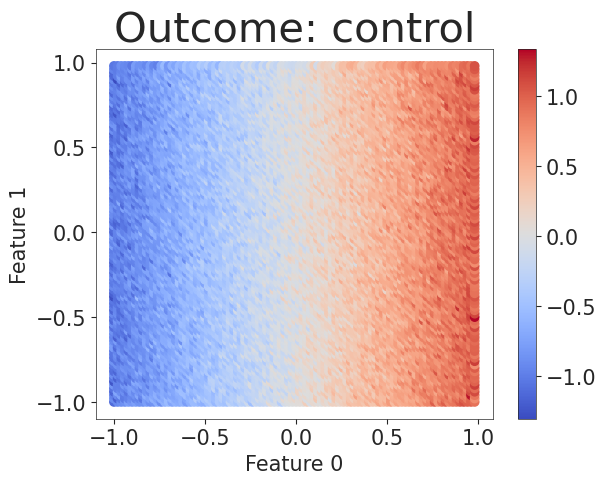

In [3]:
plt.title('Outcome: control', fontsize=30)
plt.scatter(grid[:, 0], grid[:, 1], c=control.reshape(100, 100), cmap='coolwarm')
plt.xlabel('Feature 0', fontsize=15)
plt.ylabel('Feature 1', fontsize=15)

plt.xticks(ticks=[-1,-0.5,  0, 0.5, 1], fontsize=15)
plt.yticks(ticks=[-1,-0.5,  0, 0.5, 1], fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
plt.savefig('data_ctr_scatter.png', dpi=720, facecolor='white', bbox_inches='tight')

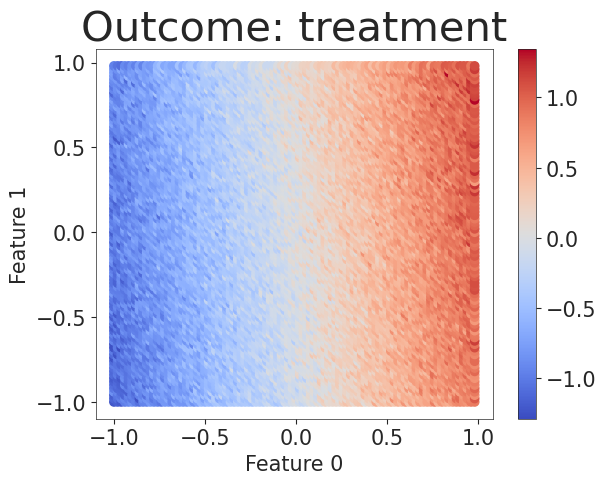

In [4]:
plt.title('Outcome: treatment', fontsize=30)
plt.scatter(grid[:, 0], grid[:, 1], c=treatment.reshape(100, 100), cmap='coolwarm')
plt.xlabel('Feature 0', fontsize=15)
plt.ylabel('Feature 1', fontsize=15)

plt.xticks(ticks=[-1,-0.5,  0, 0.5, 1], fontsize=15)
plt.yticks(ticks=[-1,-0.5,  0, 0.5, 1], fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
plt.savefig('data_tr_scatter.png', dpi=720, facecolor='white', bbox_inches='tight')

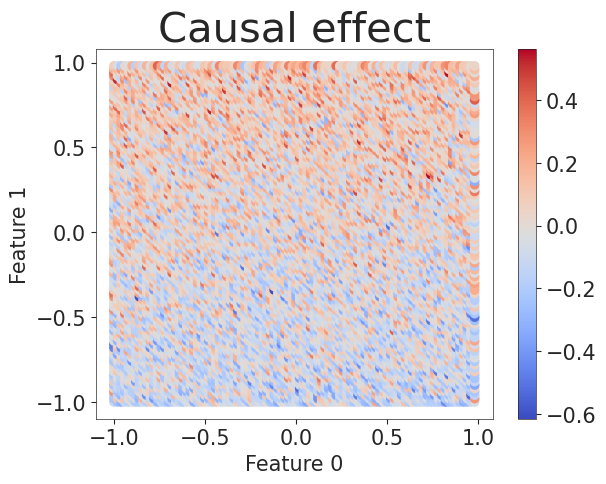

In [5]:
plt.title('Causal effect', fontsize=30)
plt.scatter(grid[:, 0], grid[:, 1], c=(treatment - control).reshape(100, 100), cmap='coolwarm')
plt.xlabel('Feature 0', fontsize=15)
plt.ylabel('Feature 1', fontsize=15)

plt.xticks(ticks=[-1,-0.5,  0, 0.5, 1], fontsize=15)
plt.yticks(ticks=[-1,-0.5,  0, 0.5, 1], fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
        
plt.savefig('data_cs_scatter.png', dpi=720, facecolor='white', bbox_inches='tight')

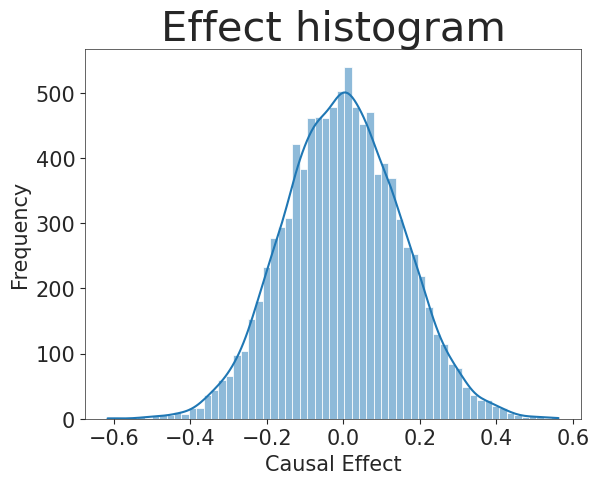

In [6]:
plt.title('Effect histogram', fontsize=30)
sns.histplot(data=pd.DataFrame({'Causal Effect': treatment - control}), x="Causal Effect", kde=True)
plt.xlabel('Causal Effect', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('data_effect_hist.png', dpi=720, facecolor='white', bbox_inches='tight')

#### Assign the random group to each observation and train/test split

In [7]:
# assign random groups
T = np.random.randint(0, 2, 10000)
# create random targets
Y = np.take_along_axis(np.stack([control, treatment], axis=1), T[:, np.newaxis], axis=1)[:, 0]
# create boosting multioutput targets
sl = T[:, np.newaxis] == np.arange(2)[np.newaxis, :]
Y_upd = np.where(sl, sl * Y[:, np.newaxis], np.nan)

# train/test split
X, X_test, y, y_test, y_upd, y_ypd_test, t, t_test, cate, cate_test = \
    train_test_split(
        grid, Y, Y_upd, T,
        treatment - control,
        test_size=0.2, random_state=42, shuffle=True
    )

#### Define the training utils

In [8]:
class MSEWithNaNLoss(MSELoss):
    """
    Regression loss that handles the NaNs in target
    """
    def __init__(self, uplift=False):
        
        self.uplift = uplift

    def base_score(self, y_true):
        # Replace .mean with nanmean function to calc base score
        means = cp.nanmean(y_true, axis=0)
        means = cp.where(cp.isnan(means), cp.nanmean(y_true), means)

        return means
        # return cp.zeros(y_true.shape[1], dtype=cp.float32)
    
    def get_grad_hess(self, y_true, y_pred):
        # first, get nan mask for y_true
        mask = cp.isnan(y_true)
        # then, compute loss with any values at nan places just to prevent the exception
        grad, hess = super().get_grad_hess(cp.where(mask, 0, y_true), y_pred)
        # invert mask
        mask = (~mask).astype(cp.float32)
        # multiply grad and hess on inverted mask
        # now grad and hess eq. 0 on NaN points
        # that actually means that prediction on that place should not be updated
        grad = grad * mask
        hess = hess * mask

        return grad, hess
    
    def postprocess_output(self, y_pred):
        
        y_pred = super().postprocess_output(y_pred)
        
        if self.uplift:
            uplift = y_pred[:, 1:] - y_pred[:, :1]

            return uplift
        
        return y_pred
    
    
class DummyMetric(Metric):
    
    def __call__(self, *args, **kwargs):
        
        return 0
    
    def compare(self, *args, **kwargs):
        
        return True
    

#### Define the model and fit

In [9]:
params = {
    'ntrees': 2000, 
    'lr':0.02, 
    'verbose':1000, 
    'es':0, 
    'lambda_l2': 0.1, 
    'gd_steps':1, 
    'subsample': 1, 
    'colsample': 1, 
    'min_data_in_leaf': 10,
    'use_hess':True, 
    'max_bin': 256, 
    'max_depth': 3,
    'min_gain_to_split': 0.03

}

loss = ComposedUpliftLoss(MSEWithNaNLoss(), 1, weight=0.5, masked=True)
metric = DummyMetric()
splitter = UpliftSplitter()

model = GradientBoosting(
    loss, metric, 
    target_splitter=splitter, 
    multioutput_sketch=RandomSamplingSketchX(1, smooth=1),
    callbacks=[
        loss, 
    ], 
    debug=True,
    **params
)


In [10]:
model.fit(X, y_upd)

[00:56:11] Stdout logging level is INFO.
[00:56:11] GDBT train starts. Max iter 2000, early stopping rounds 0
[00:56:12] Iter 0; 
[00:56:18] Iter 1000; 
[00:56:22] Iter 1999; 


#### Make prediction from the different parts of ensemble

In [11]:
# outcome model
model.loss.weight = 0
pred_o = model.predict(X_test)[:, 0]
print('R2 score outcome', r2_score(cate_test, pred_o))


# uplift model
model.loss.weight = 1
pred_u = model.predict(X_test)[:, 0]
print('R2 score uplift', r2_score(cate_test, pred_u))


# averaged model
model.loss.weight = 0.5
pred_w = model.predict(X_test)[:, 0]
print('R2 score average', r2_score(cate_test, pred_w))

R2 score outcome 0.15818699835326544
R2 score uplift 0.1589115034934261
R2 score average 0.15955150177683775


#### Analyze the results

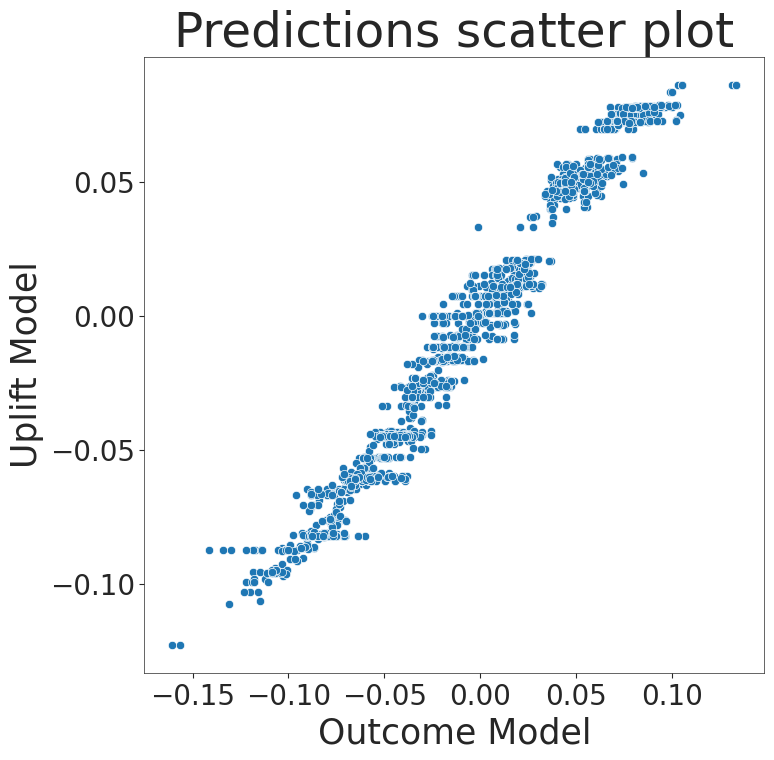

In [12]:
df = pd.DataFrame({
    
    'Outcome Model': pred_o,
    'Uplift Model': pred_u,
    
})

plt.figure(figsize=(8, 8))
plt.title('Predictions scatter plot', fontsize=35)
sns.scatterplot(data=df, x='Outcome Model', y='Uplift Model')

plt.xlabel('Outcome Model', fontsize=25)
plt.ylabel('Uplift Model', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('pred_scatter.png', dpi=720, facecolor='white', bbox_inches='tight')

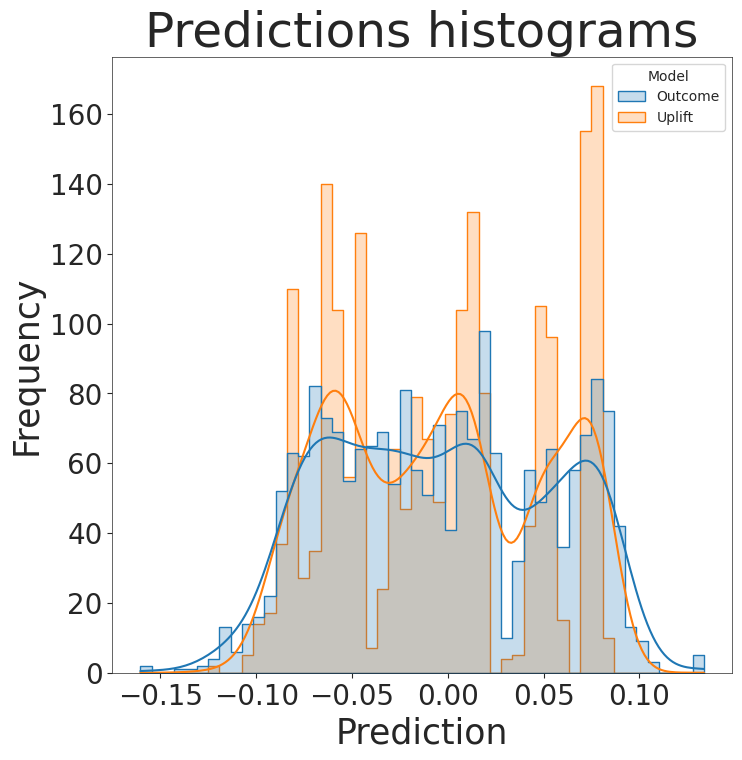

In [13]:

df = pd.DataFrame({
    
    'Prediction': np.concatenate([pred_o, pred_u]),
    'Model': ['Outcome'] * len(pred_o) + ['Uplift'] * len(pred_u)
    
})

plt.figure(figsize=(8, 8))
plt.title('Predictions histograms', fontsize=35)
ax = sns.histplot(data=df, x="Prediction", kde=True, hue='Model', palette='tab10', element="step", bins=50, legend=True)
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('pred_hist_kde.png', dpi=720, facecolor='white', bbox_inches='tight')

#### Importances

In [ ]:
model.to_cpu()

imp = np.zeros((2, 3), dtype=np.float32)
for mod in model.models:
    np.add.at(imp[0], mod.feats[0], 1)
    np.add.at(imp[1], mod.feats[1], 1)
    
imp[: ,:2]

array([[1594.,  889.],
       [ 299.,  900.]], dtype=float32)